# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd 
import numpy as np


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_age = pd.read_csv('/datasets/faces/labels.csv')
df_age.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем df 7591 строк и 2 столбца, один столбец типа int64, а второй столбец типа object. Пропущенных значений нет.

In [4]:
df_age.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В нашем df минимальный возраст человека 1 год, а максимальный возраст 100. Средний возраст 31 год, медиана в районе 29 лет. Построим график

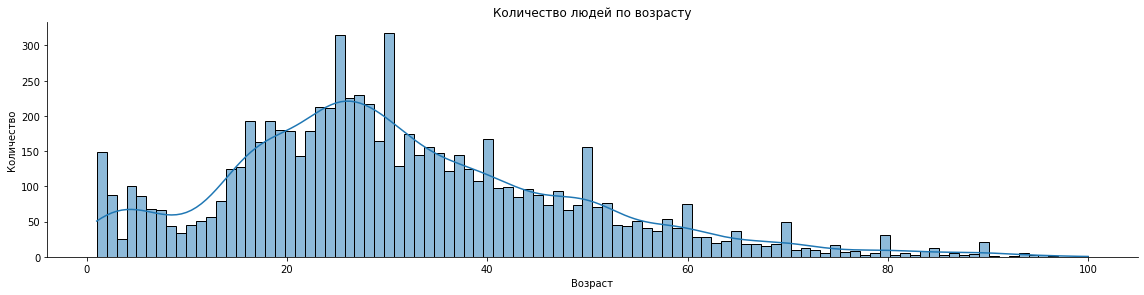

In [5]:
sns_plot = sns.displot(df_age, 
                       x="real_age",
                       kde=True,
                       height = 4,
                       aspect = 4,
                       bins=df_age.real_age.max())
plt.title("Количество людей по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Количество") ;

В основном в нашем df люди возрастом от 2 до 60 лет, людей с возрастом более 60 маленькое кол-во, но всё же они есть. Больше всего в df людей с возрастом 17-30 лет. На графике наблюдаются некоторые пики в юбилейные года, а именно 25, 30, 40, 50, 60 и т д. возможно это связано с тем, что в юбилеи, люди делают большее количество фото(на память), поэтому их больше чем в промежутке между этими годами, а так же, как вариант просто совпадение или же, в df на фото знаменитости(и папарации в их ДР делают много фото), а после их рандомно выбрали и они попали к нам в df.

In [6]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=.2,
    height_shift_range=.2
)


validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

In [7]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = df_age,
    directory = '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=16,
    subset='training',
    seed=69)

val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe = df_age,
    directory = '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=16,
    subset='validation',
    seed=69)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


В обучающей выборке 5694 изображений, в валидационной 1897 изображений.

In [8]:
features, target = next(train_datagen_flow)
print(features.shape)

(16, 224, 224, 3)


In [9]:
features_valid, target_valid = next(val_datagen_flow)
print(features_valid.shape)

(16, 224, 224, 3)


Четырёхмерный тензор, в котором 16 изображений размером 224x224 с тремя цветовыми каналами

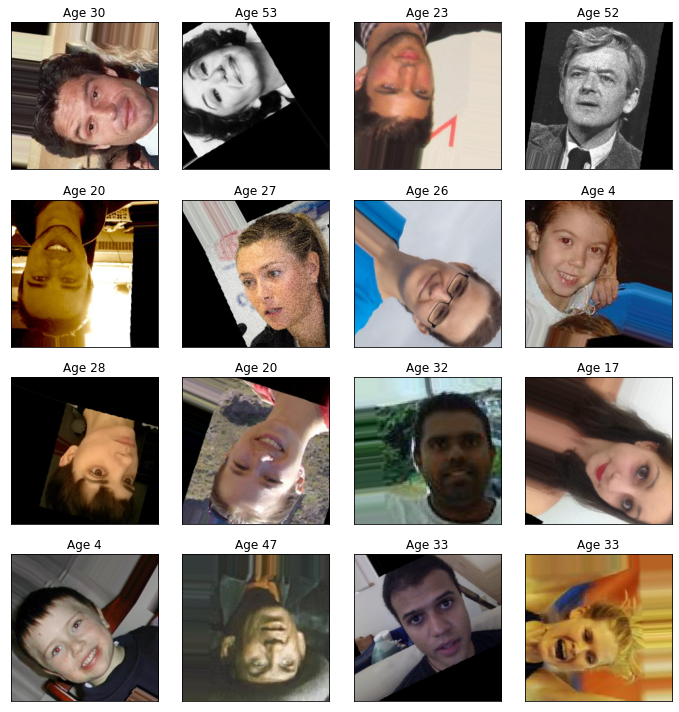

In [13]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age {}'.format(target[i]))
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Данные размечены верно.

**Вывод**

В df 7591 строк и 2 столбца, один столбец типа int64, а второй столбец типа object. Пропущенных значений нет. В отдельной папке у нас изображения. Возраст и изображения соответствуют друг другу. Так же можно отметить, что изображения есть и в цветном и в черно-белом формате. В принципе, данных для обучения достаточно, но чем их больше, тем лучше.

## Обучение модели

In [12]:
def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=90,
    width_shift_range=.2,
    height_shift_range=.2
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory = path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=32,
    subset='training',
    seed=69)
       
    return train_datagen_flow



def load_test(path):
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
    )
      
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory = path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=32,
    subset='validation',
    seed=69)
 
    return test_datagen_flow
    
    

def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=25,
               steps_per_epoch=None, validation_steps=None):
               
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```
60/60 - 10s - loss: 85.9127 - mae: 6.5253. 
Test MAE: 6.5253

```

## Вывод

В данном проекте, построили модель, которая по фотографии определит приблизительный возраст человека. Даннах было не так много, всего 7591. Большинство людей от 17 - 40 лет, остальных намного меньше, с чем это связано, не особо понятно. Ранее делались предположения на этот счет. Так же у нас есть всплески в данных в юбилейных годах, возможно это связано с днем рождением и данные собирались из какой-то выборки, где большая часть фотографий была со дня рождения. На обучающей выборке использовали аугментацию, а именно: horizontal_flip, vertical_flip, rotation_range, width_shift_range и height_shift_range. На test оставили 25% данных. Использовали модель ResNet50. Итоговая метрика на test MAE: 6.5253. В принципе, построенная модель может быть использована для рекомендации товаров, которые могут заинтересовать покупателей. Контролировать добросовестность кассиров еще рано. Ошибка в +/- 6.5 лет велика. Мы же не хотим продавать алкоголь 13-тилетним.